In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use('arviz-darkgrid')

#### Code 4.1

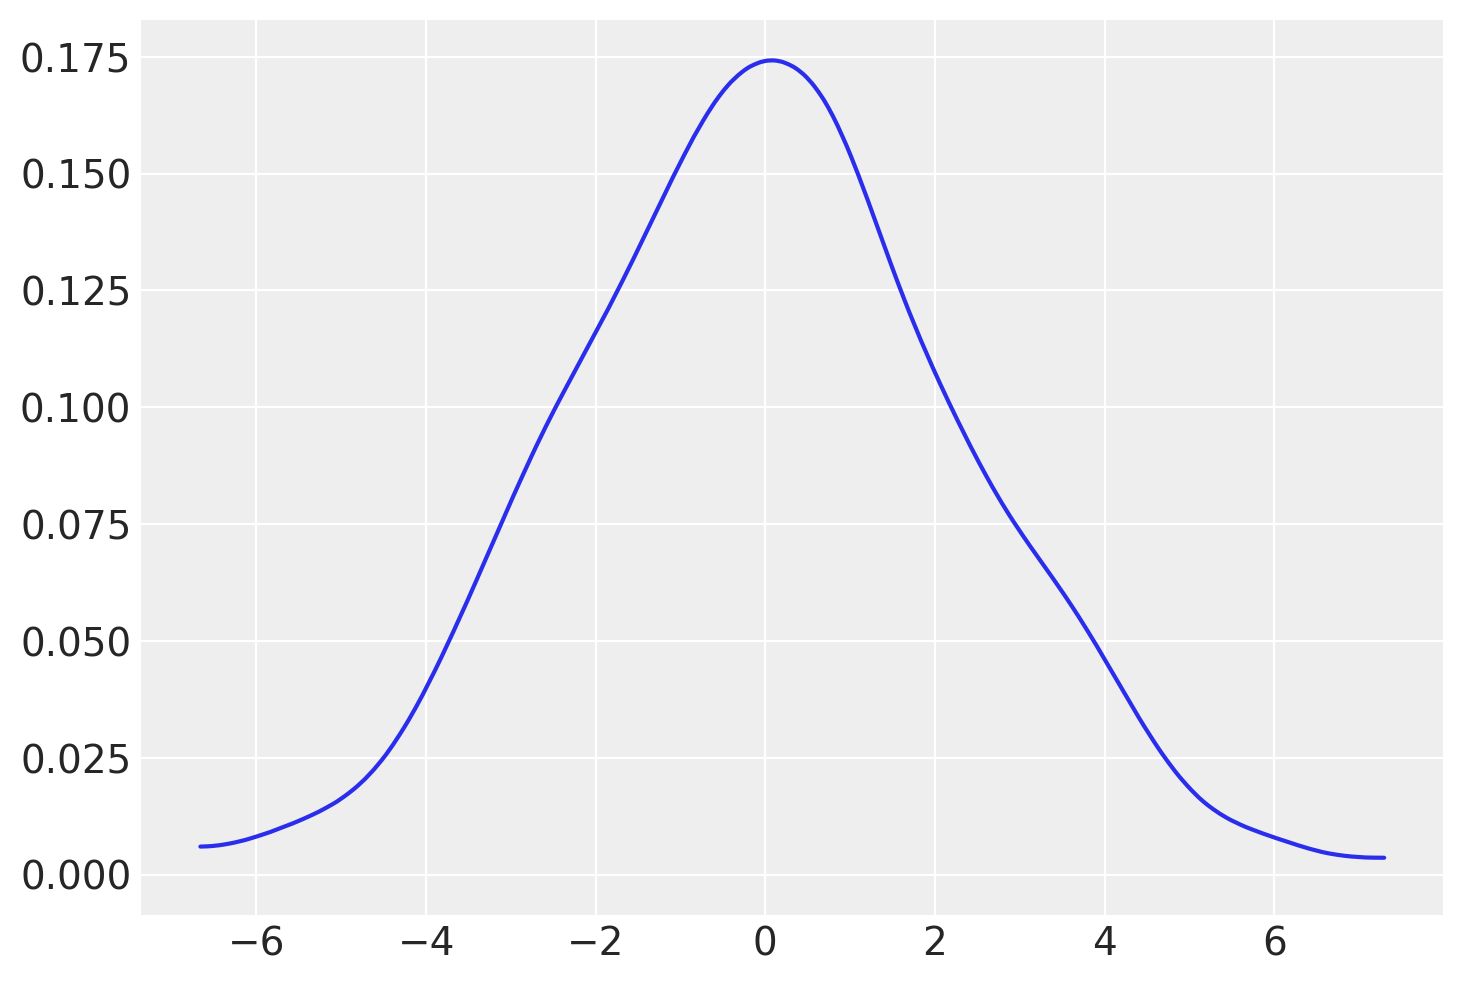

In [3]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos);

#### Code 4.2 and 4.3

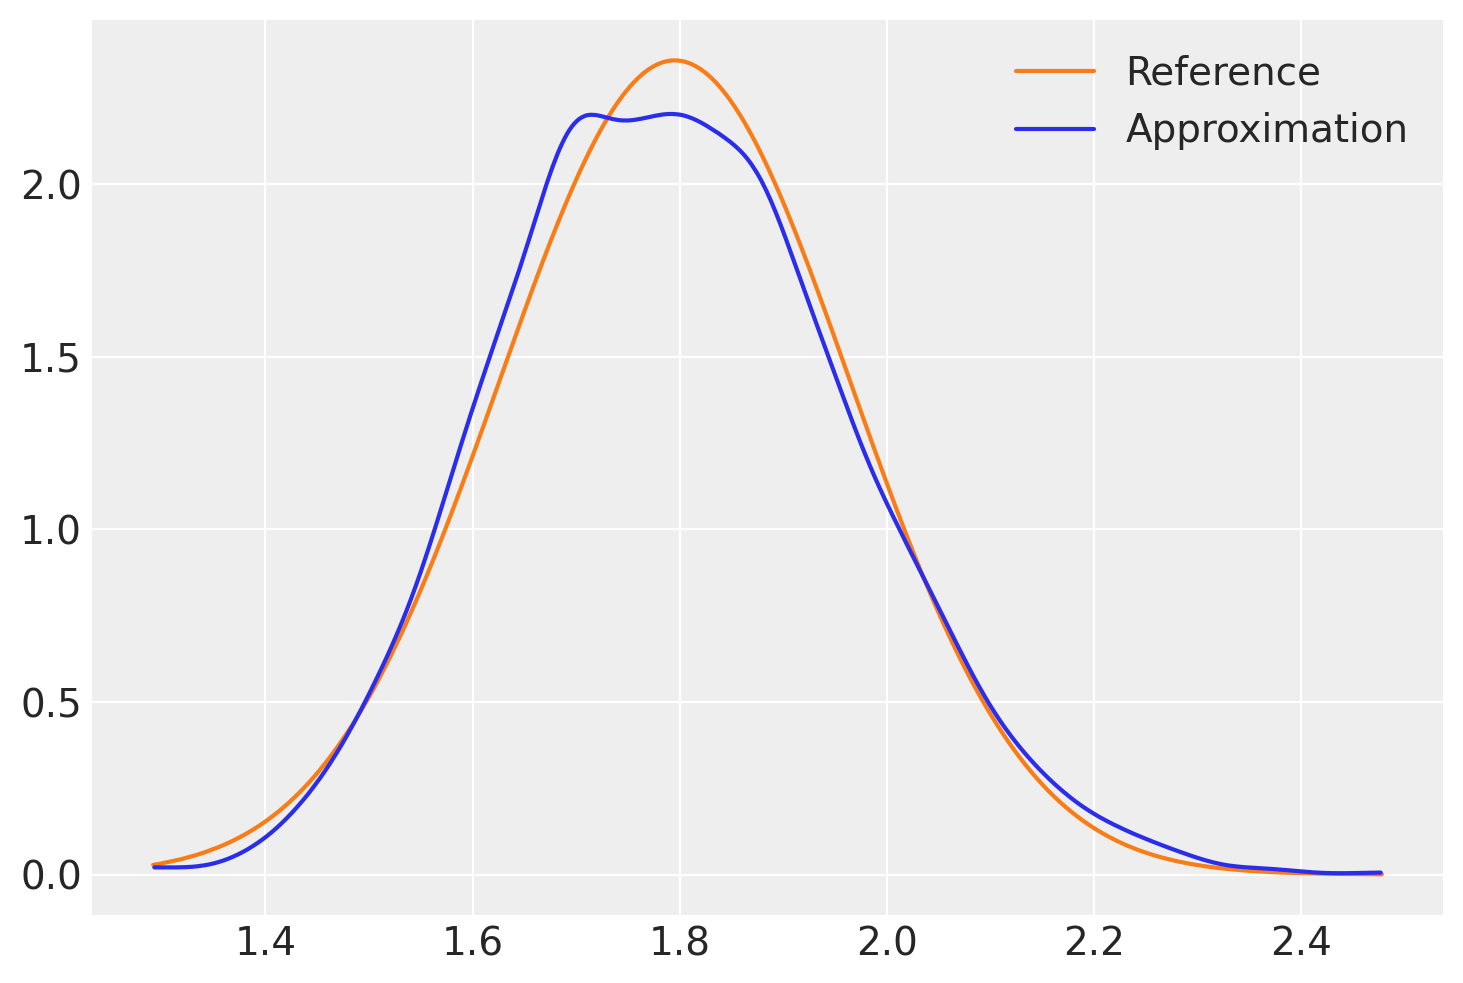

In [4]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
pos_sorted = np.sort(pos)
reference_normal_pdf = stats.norm.pdf(x=pos_sorted, loc=pos.mean(), scale=pos.std())
plt.plot(pos_sorted, reference_normal_pdf, color="C1", label="Reference")
az.plot_kde(pos, label="Estimate")
plt.legend(loc=0);

#### Code 4.4

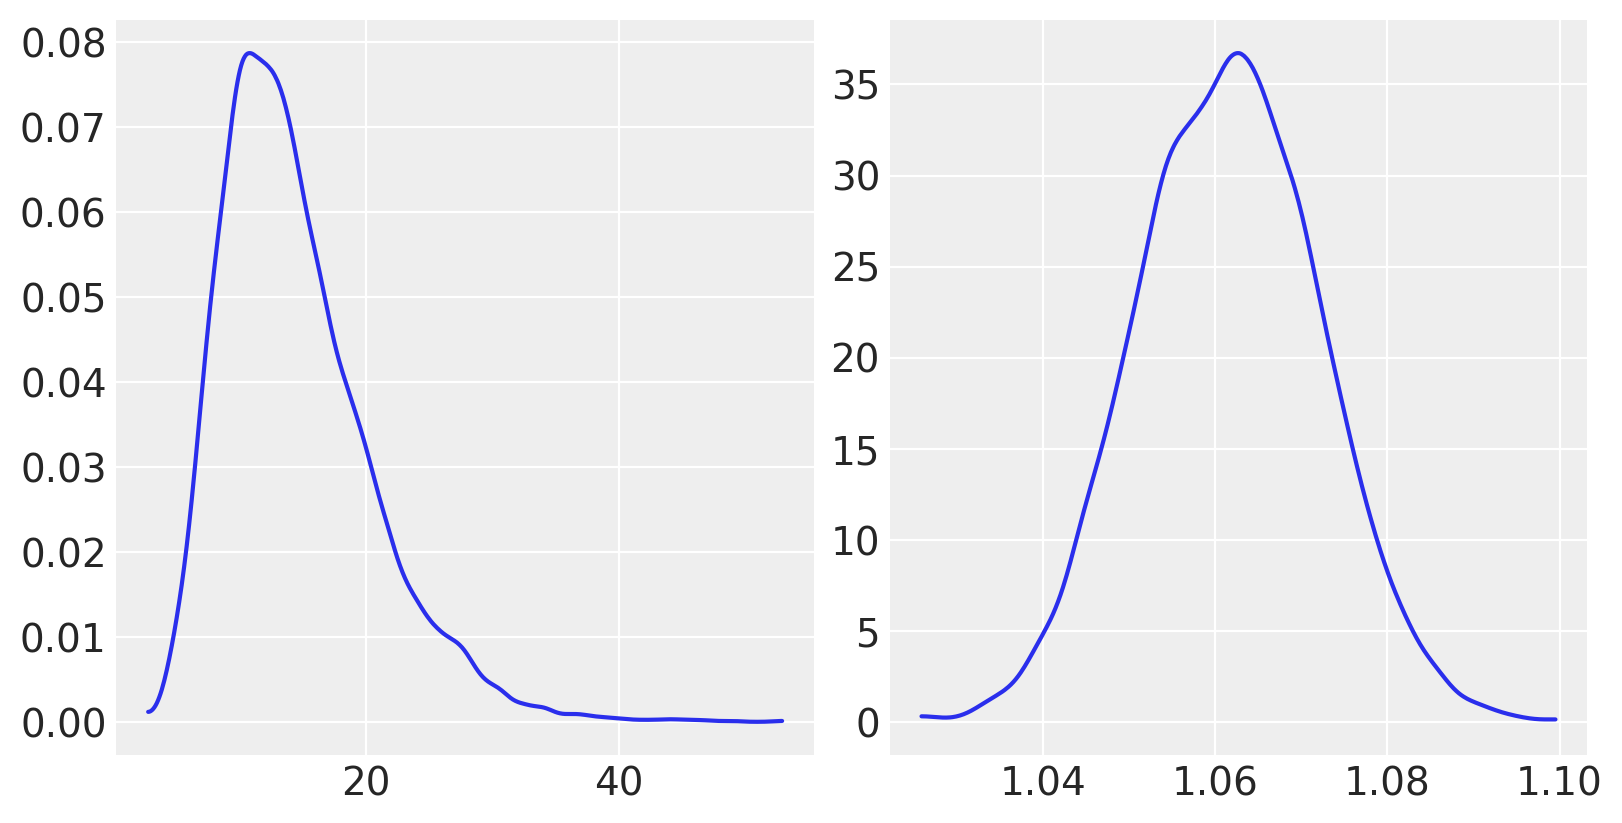

In [5]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

#### Code 4.5

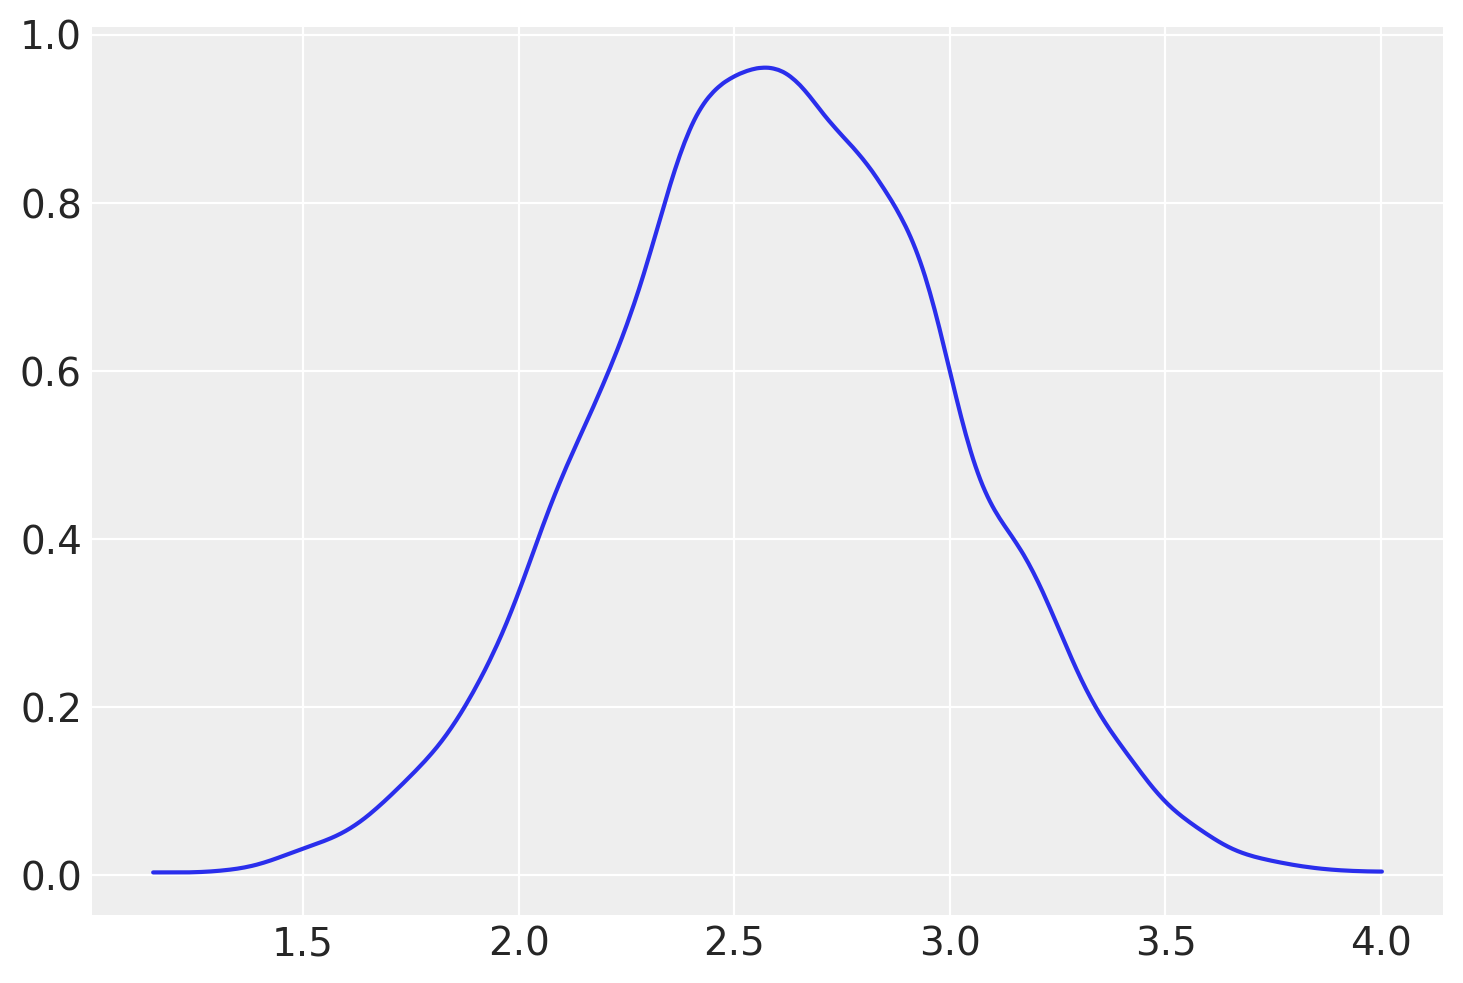

In [6]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

#### Code 4.6

We are going to use the same function we use on chapter 2 (code 2.3)

In [7]:
def posterior_grid_approx(grid_points=100, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    # prior = (p_grid >= 0.5).astype(int)  # truncated
    # prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

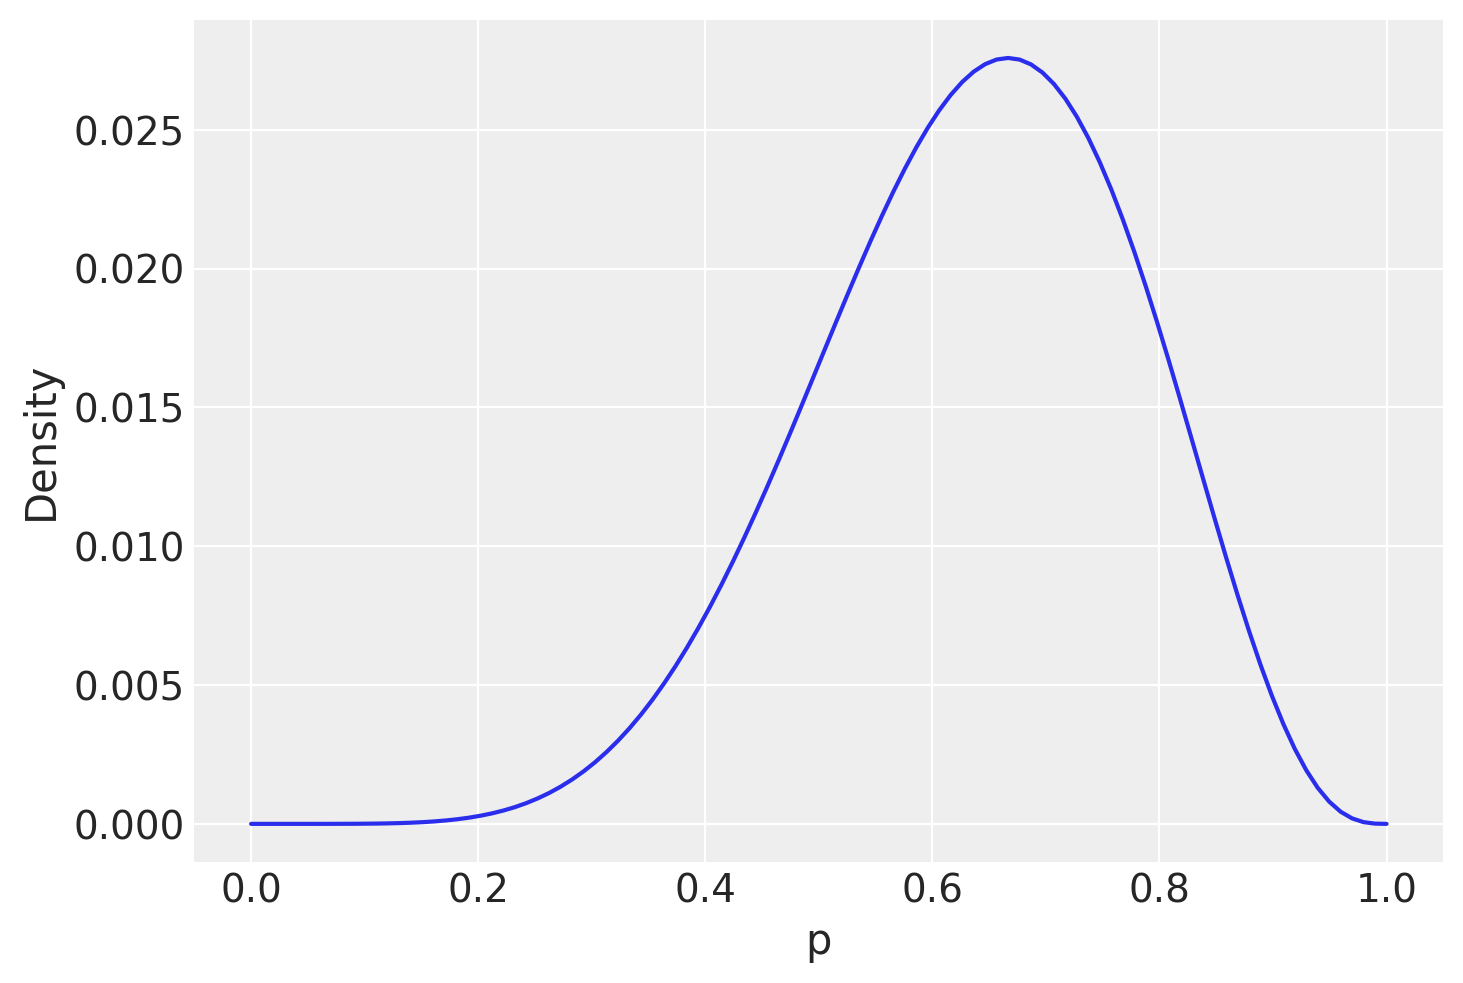

In [8]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

#### Code 4.7 and 4.8

Datasets are located in the 'data' folder.

In [9]:
d = pd.read_csv('data/Howell1.csv')
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.9

In [10]:
d.describe(percentiles=[0.055, 0.945], )

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
5.5%,81.108550,9.360721,1.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
94.5%,165.735000,54.502894,66.135000,1.000000
max,179.070000,62.992589,88.000000,1.000000


#### Code 4.10

In [11]:
d.height # or d['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

#### Code 4.11

In [12]:
d2 = d[d.age >= 18]

#### Code 4.12

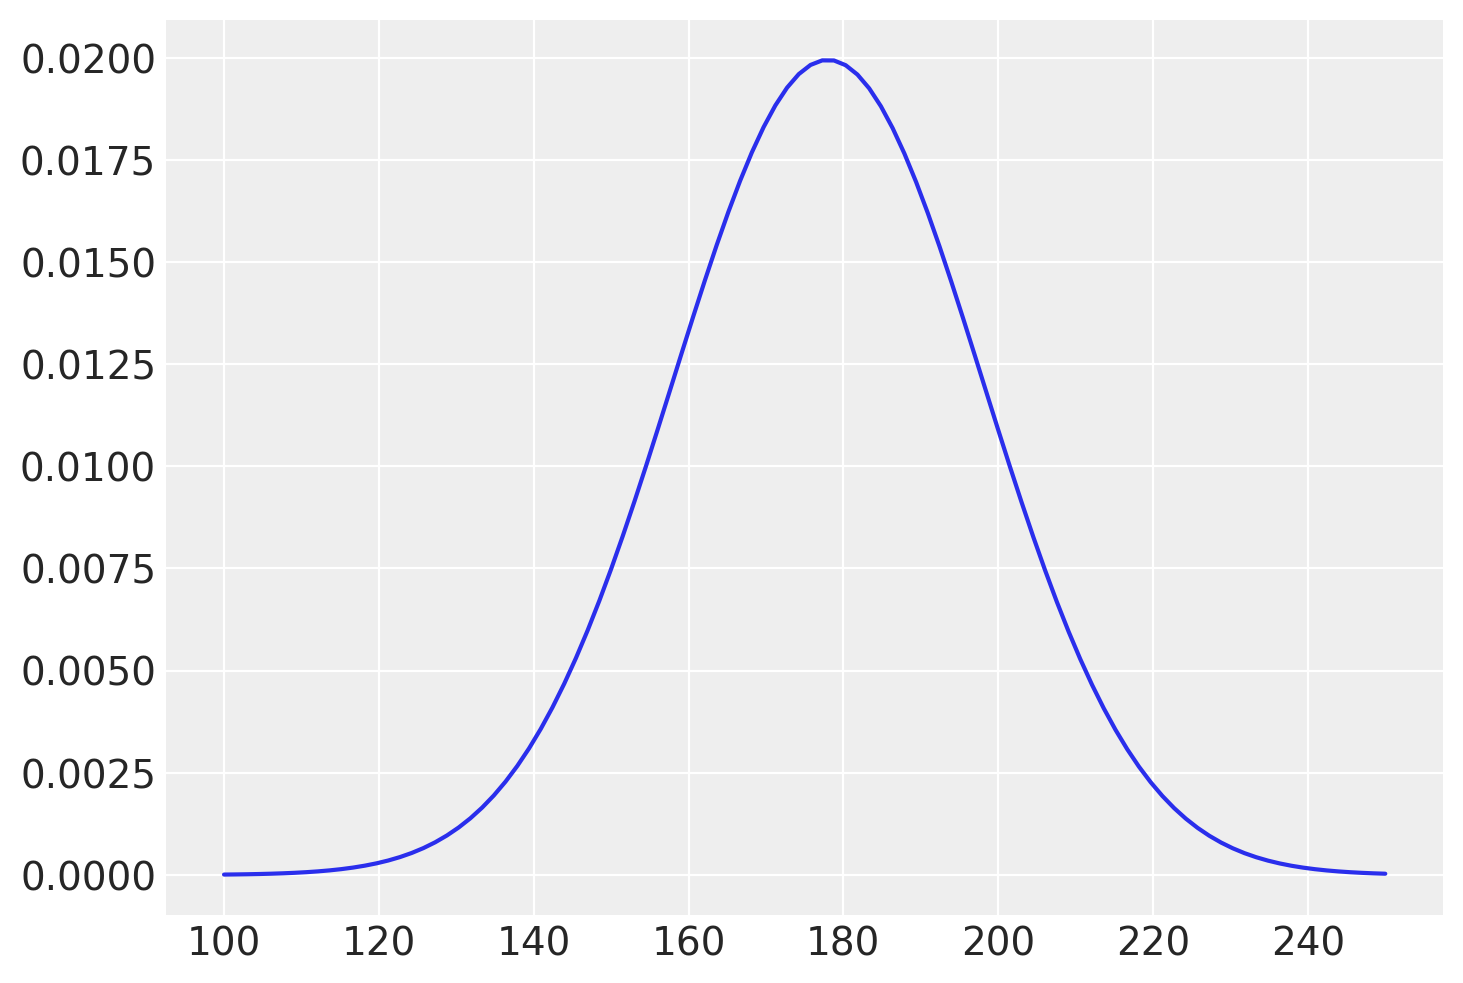

In [13]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.13

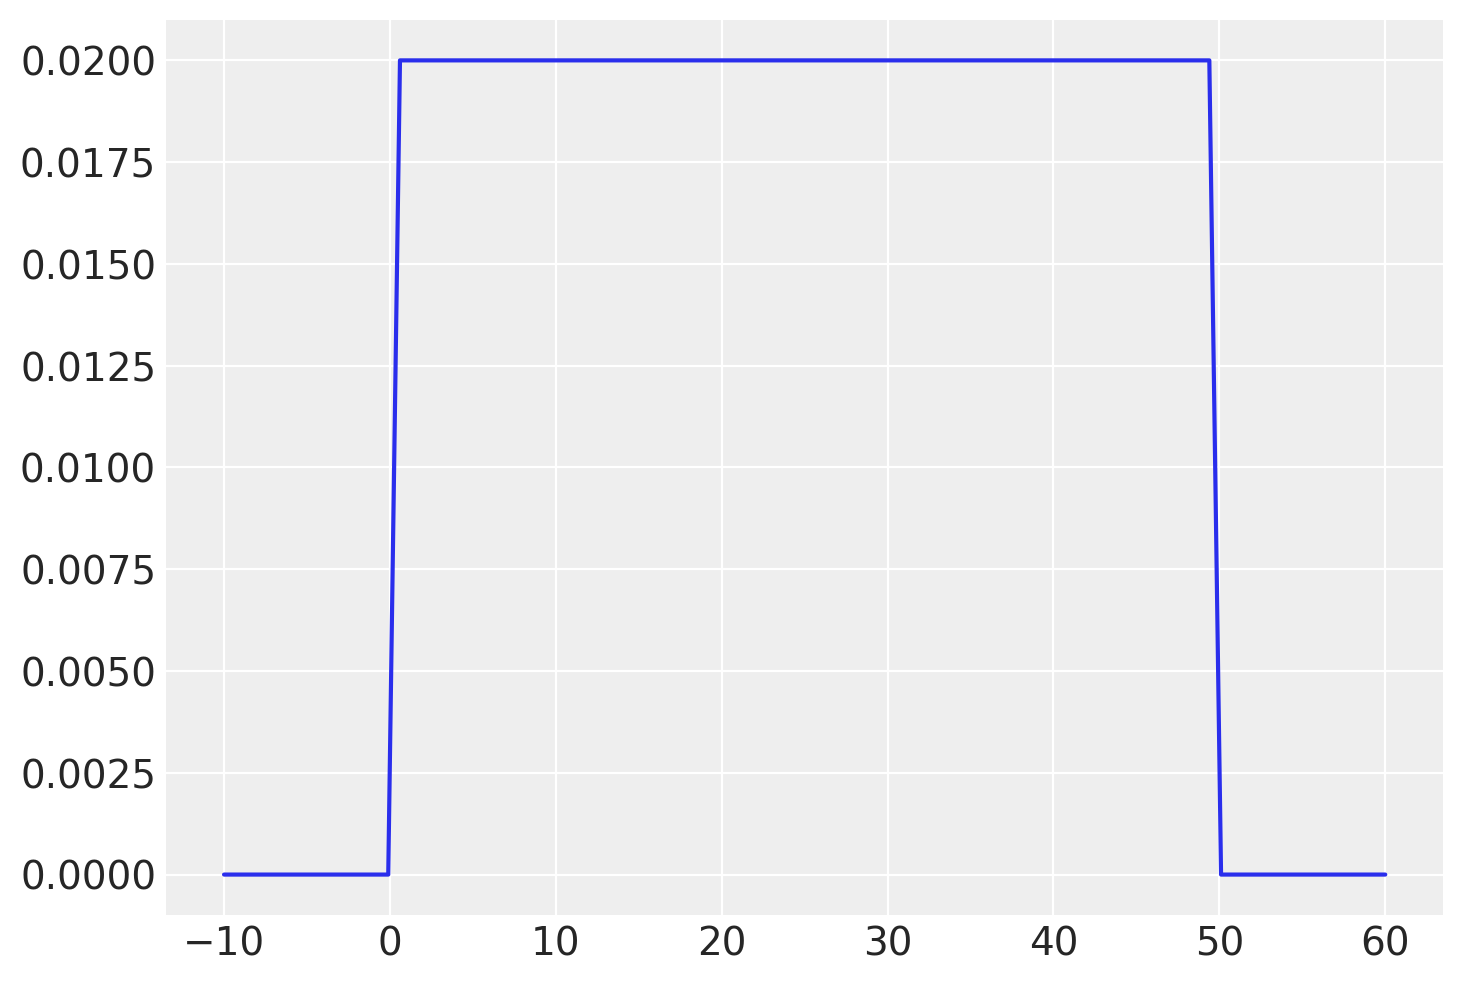

In [14]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.14

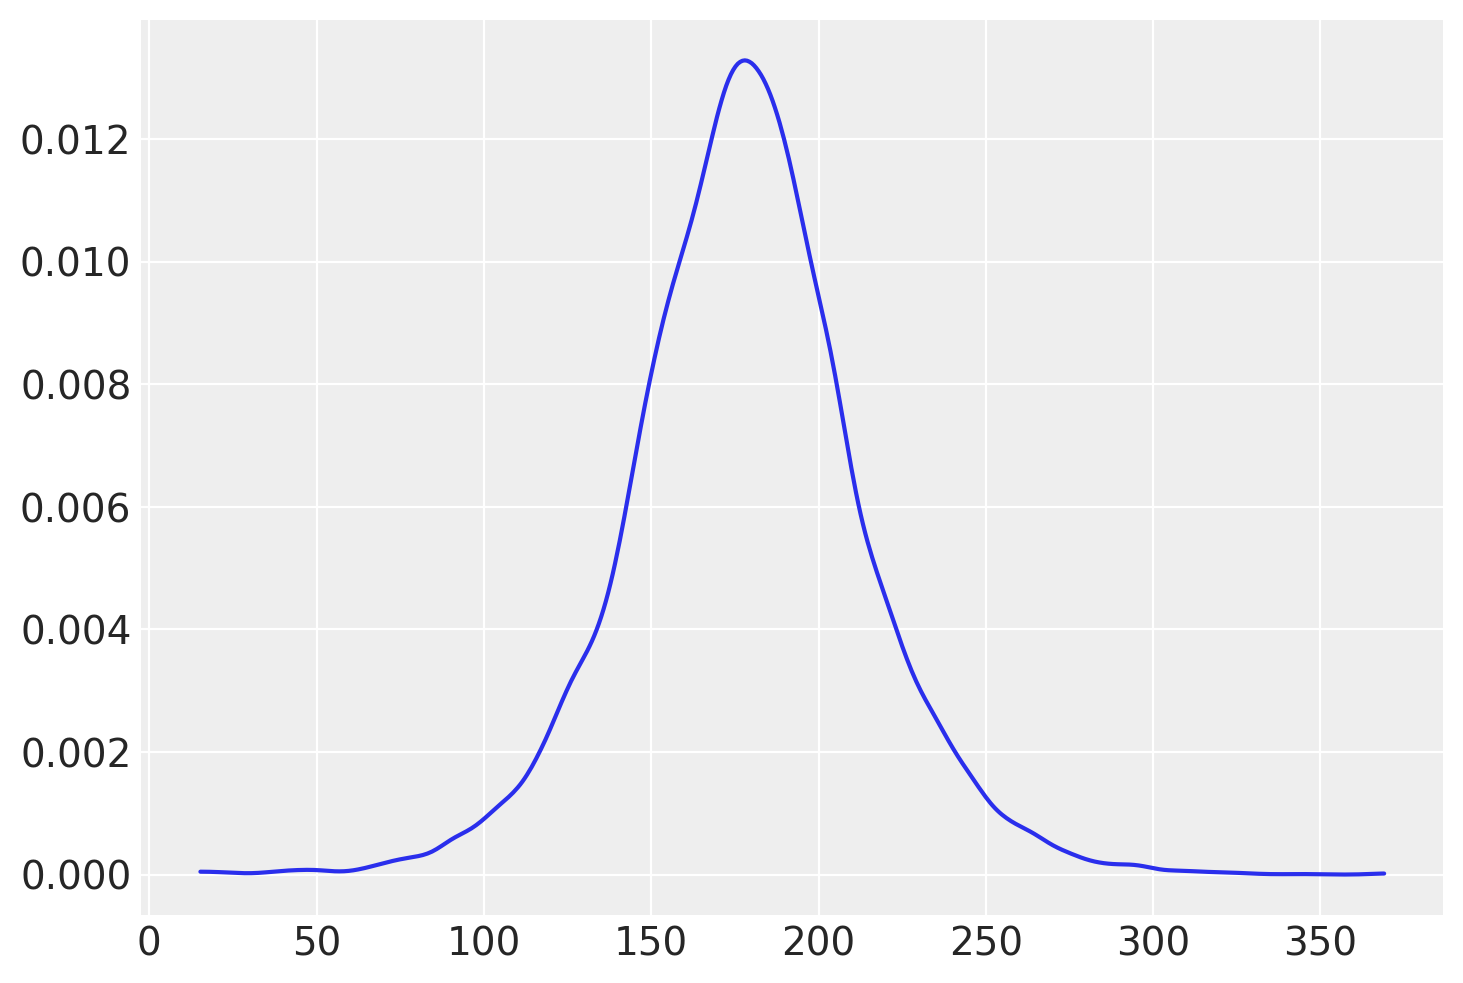

In [15]:
n = int(1e4)
sample_mu = stats.norm.rvs(178, 20, size=n)
sample_sigma = stats.uniform.rvs(0, 50, size=n)
prior_h = stats.norm.rvs(sample_mu, sample_sigma) # size is not required

az.plot_kde(prior_h);

#### Code 4.15

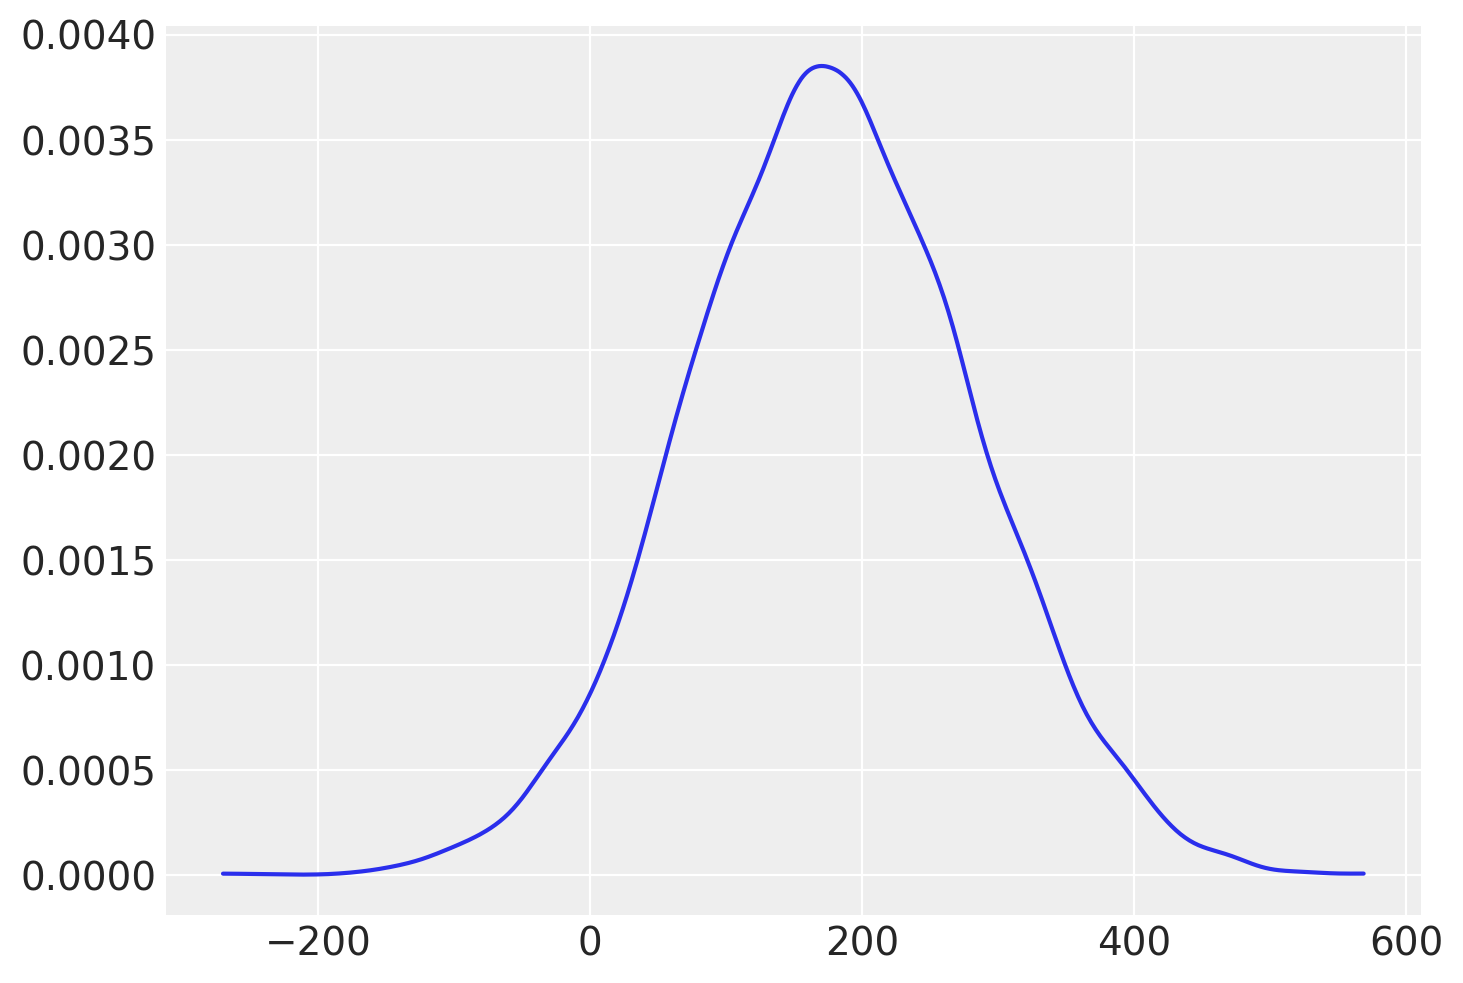

In [16]:
n = int(1e4)
sample_mu = stats.norm.rvs(178, 100, size=n)
prior_h = stats.norm.rvs(sample_mu, sample_sigma)
az.plot_kde(prior_h);

#### Code 4.16

In [78]:
mu_list = np.linspace(150, 160, num=100)
sigma_list = np.linspace(7, 9, num=100)
post = pd.DataFrame(np.array(np.meshgrid(mu_list, sigma_list)).reshape(2,-1).T, columns=["mu", "sigma"])
post['LL'] = [
    stats.norm.logpdf(d2.height, loc=post.mu[i], scale=post.sigma[i]).sum() 
    for i in post.index
]Approximation
post['prod'] = post.LL + stats.norm.logpdf(post.mu, loc=178, scale=20) + stats.uniform.logpdf(post.sigma, 0, 50)
post['prob'] = np.exp(post['prod'] - post['prod'].max())

#### Code 4.17

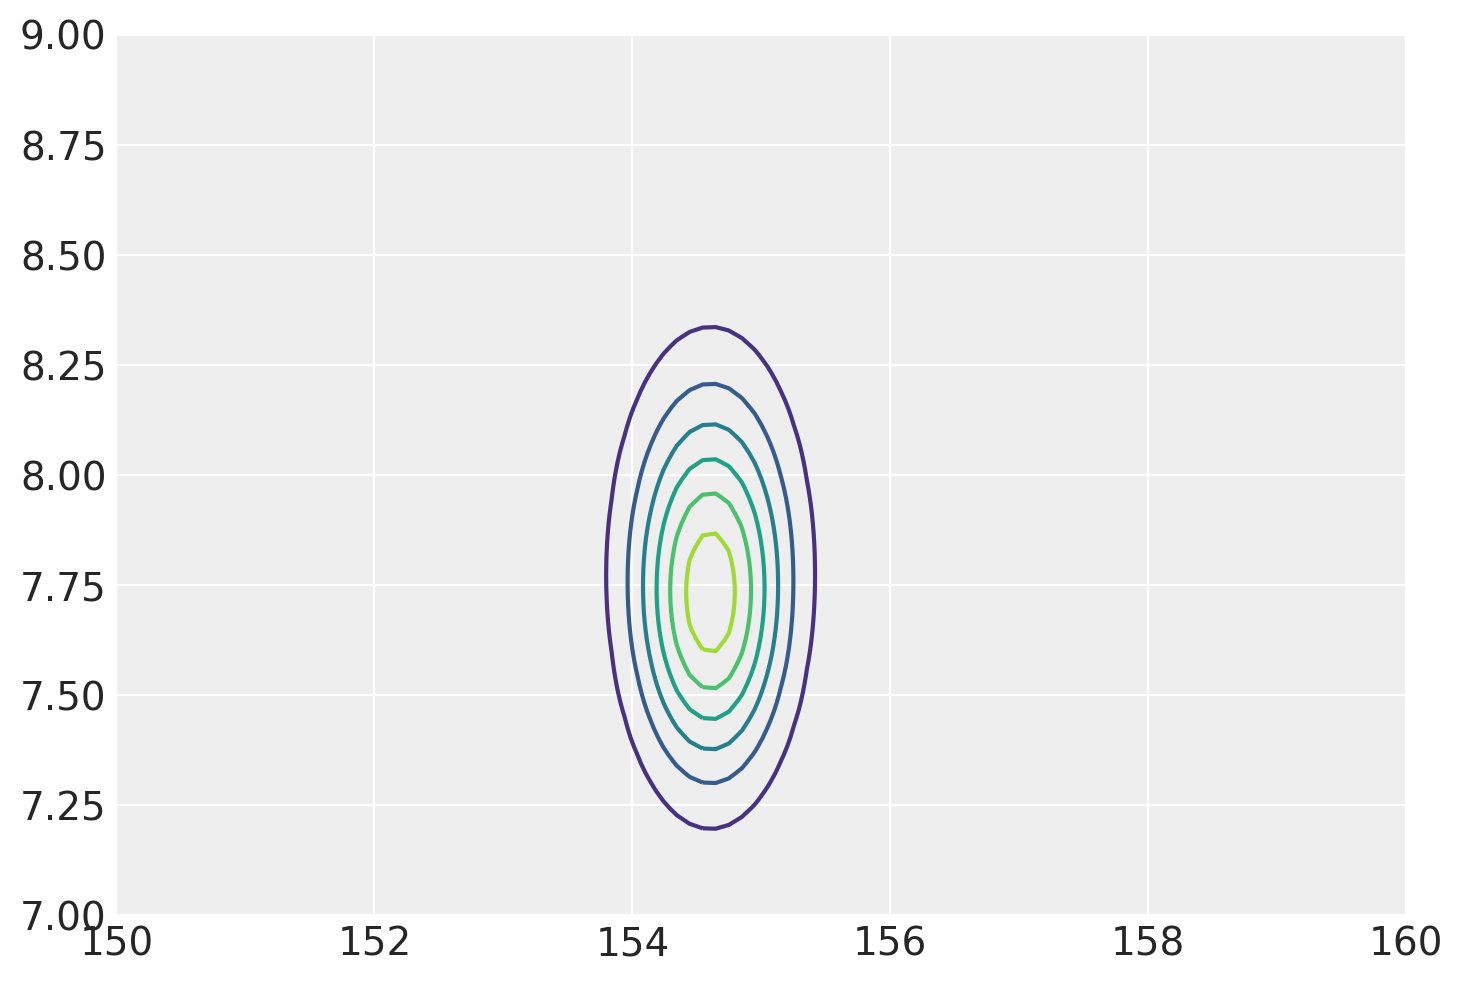

In [79]:
xi = np.linspace(post['mu'].min(), post['mu'].max(), 100)
yi = np.linspace(post['sigma'].min(), post['sigma'].max(), 100)
zi = griddata((post['mu'], post['sigma']), post['prob'] , (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Code 4.18

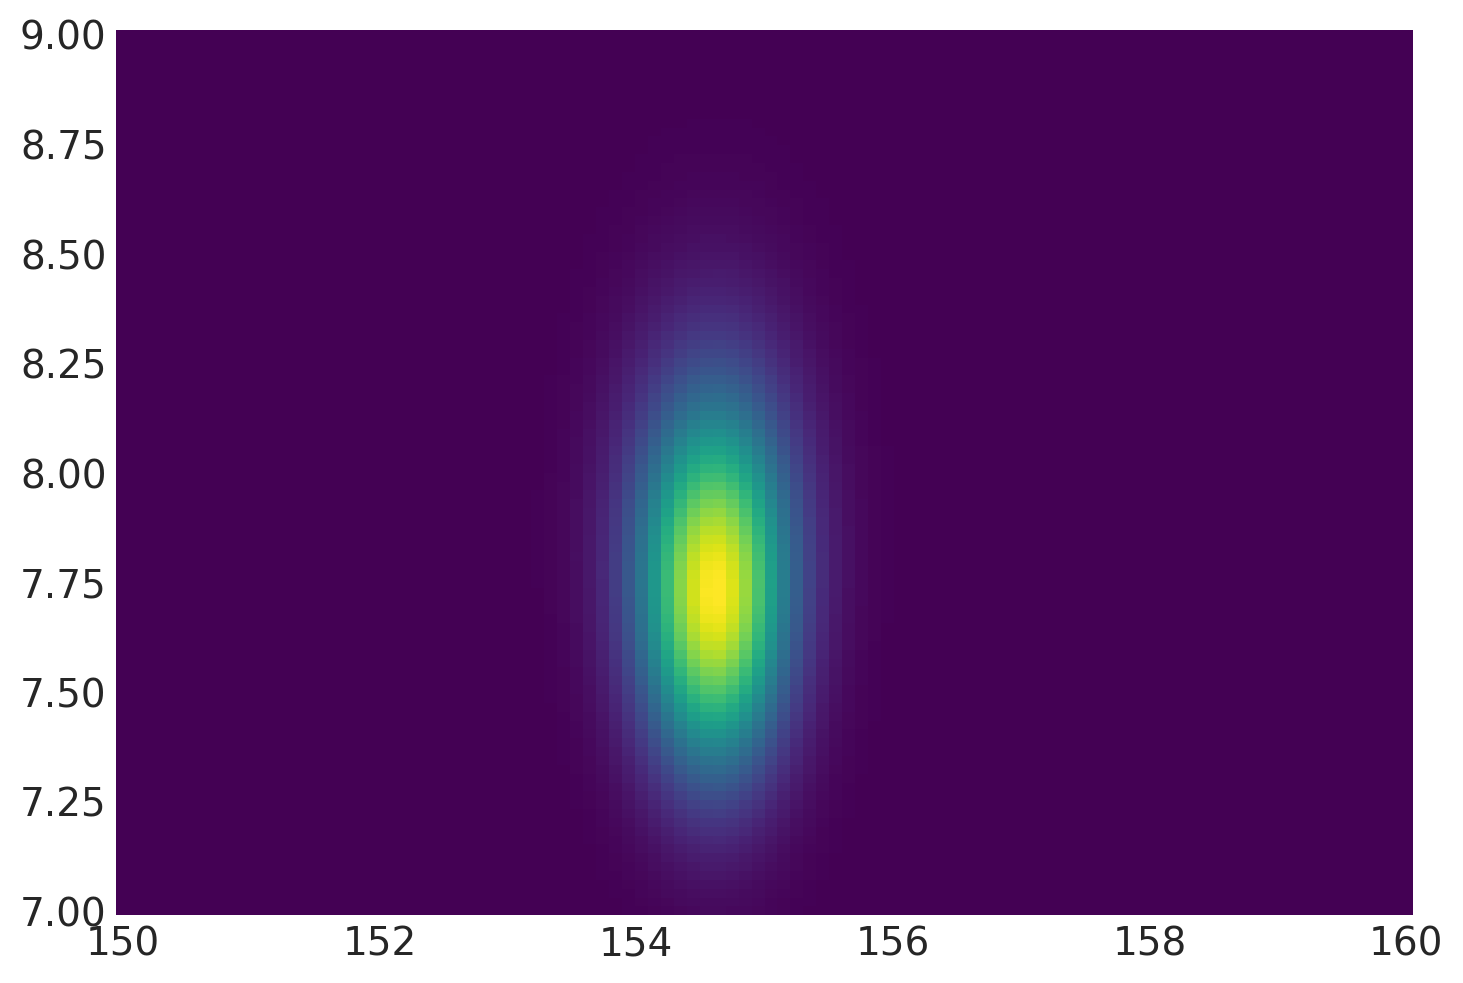

In [80]:
plt.pcolormesh(xi, yi, zi, shading='auto');

#### Code 4.19

In [81]:
sample_rows = np.random.choice(post.index, size=int(1e4), replace=True, p = post['prob'] / post['prob'].sum())
sample_mu = post.mu[sample_rows]
sample_sigma = post.sigma[sample_rows]

#### Code 4.20

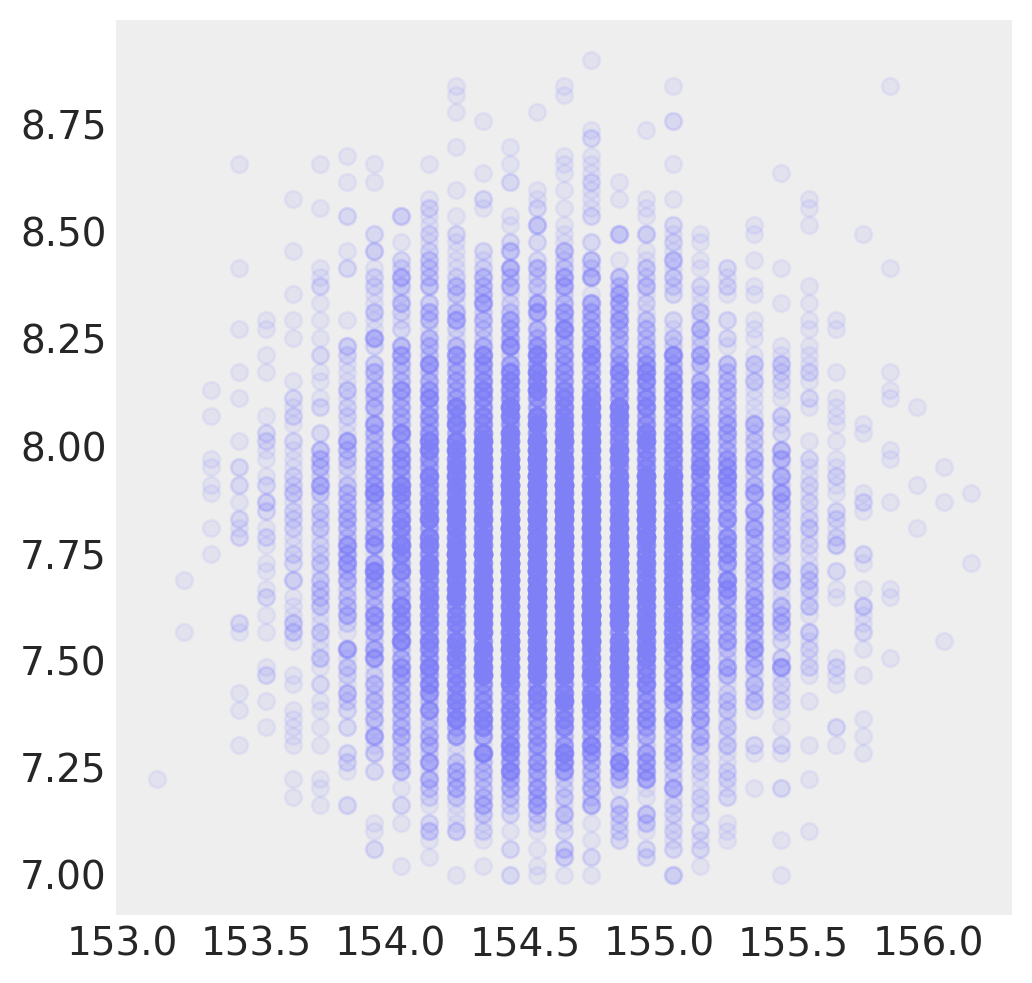

In [114]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.plot(sample_mu, sample_sigma, 'o', color="#8080FF", alpha=0.1)
ax.grid(False);

#### Code 4.21

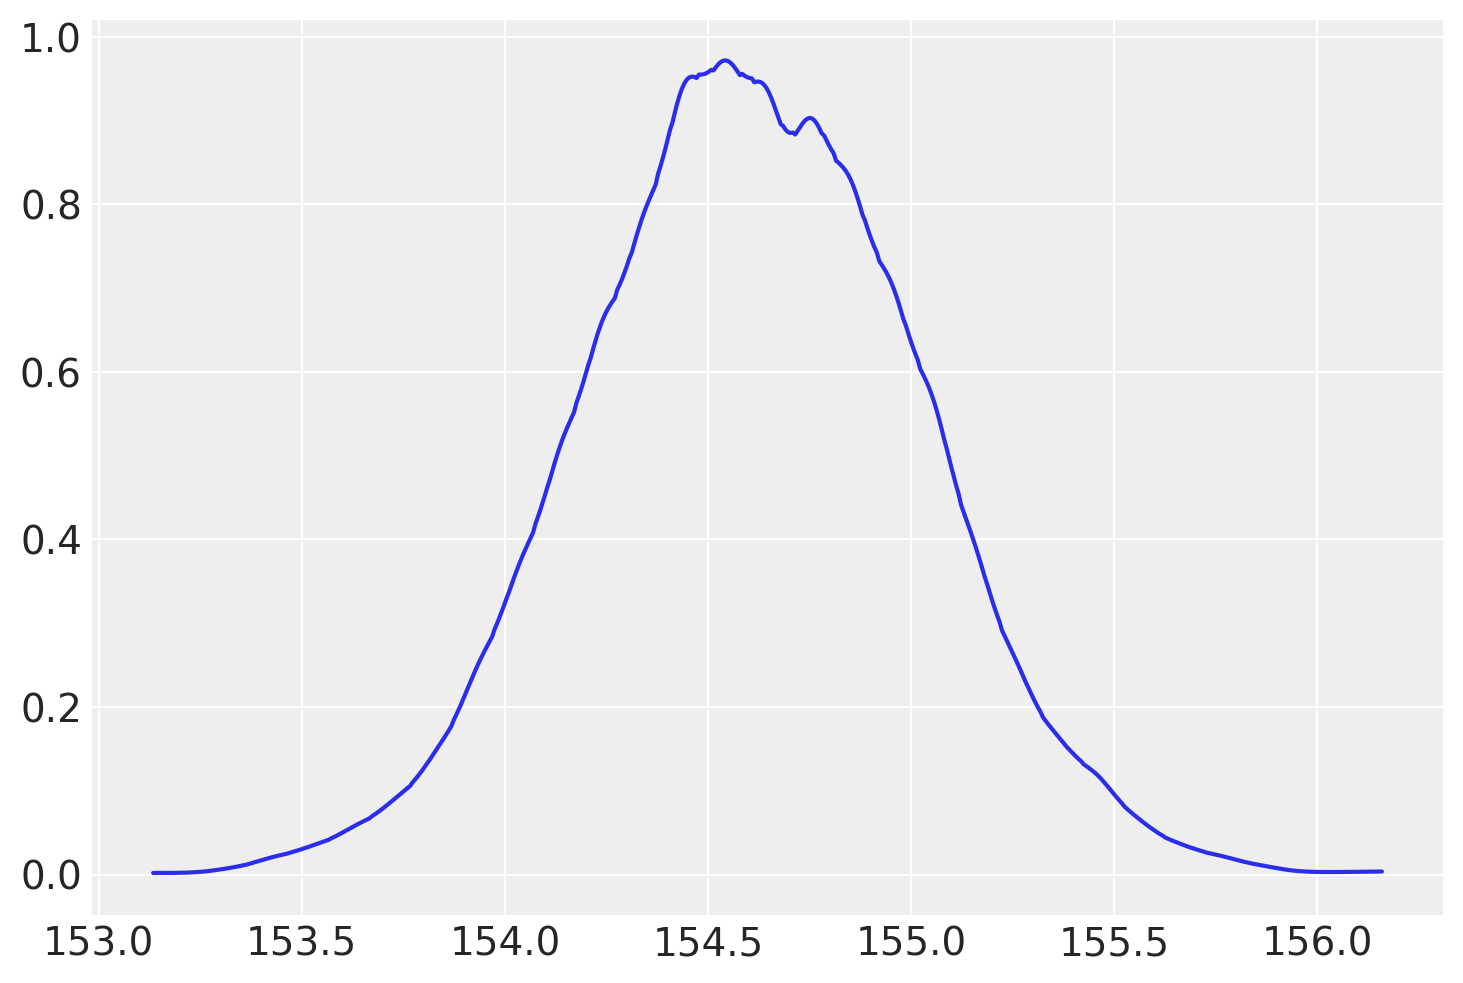

In [83]:
az.plot_kde(sample_mu, bw="silverman");

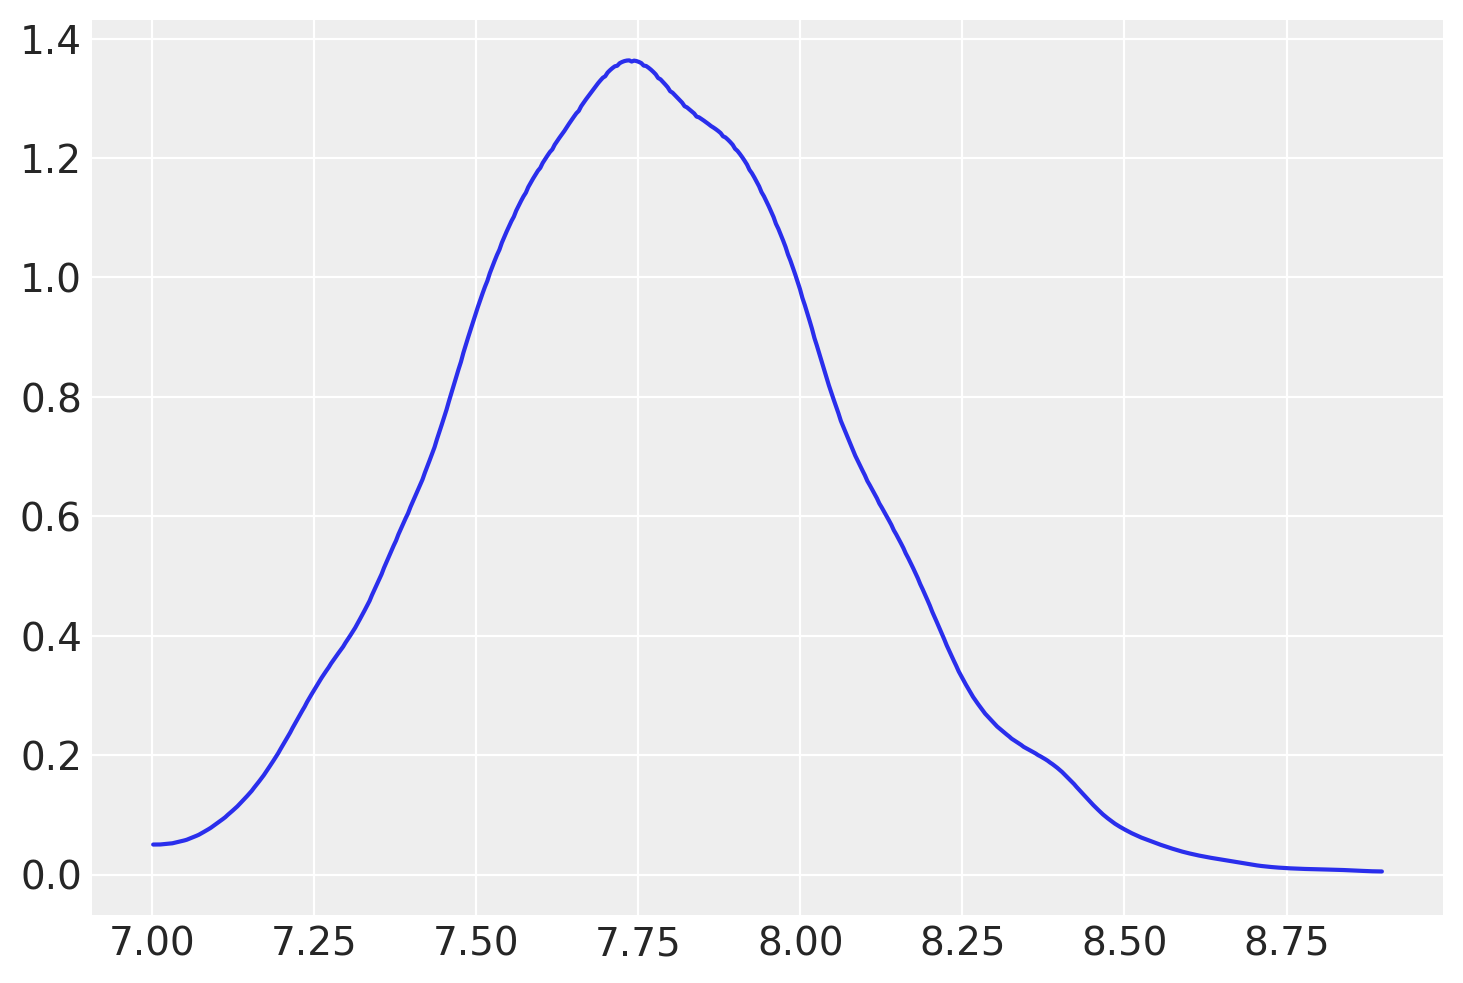

In [84]:
az.plot_kde(sample_sigma, bw="silverman");

#### Code 4.22

In [87]:
np.quantile(sample_mu, q=[0.04, 0.95])

array([153.93939394, 155.25252525])

In [88]:
np.quantile(sample_sigma, q=[0.04, 0.95])

array([7.2820202 , 8.27272727])

#### Code 4.23

In [89]:
d3 = np.random.choice(d2.height, size=20)

#### Code 4.24

In [109]:
mu_list = np.linspace(150, 170, num=200)
sigma_list = np.linspace(4, 20, num=200)
post2 = pd.DataFrame(np.array(np.meshgrid(mu_list, sigma_list)).reshape(2, -1).T, columns=["mu", "sigma"])
post2['LL'] = [
    stats.norm.logpdf(d3, loc=post2.mu[i], scale=post2.sigma[i]).sum() 
    for i in post2.index
]
post2['prod'] = post2.LL + stats.norm.logpdf(post2.mu, 178, 20) + stats.uniform.logpdf(post2.sigma, 0, 50)
post2['prob'] = np.exp(post2['prod'] - post2['prod'].max())

sample2_rows = np.random.choice(post2.index, size=int(1e4), replace=True, p = post2['prob'] / post2['prob'].sum())
sample2_mu = post2.mu[sample2_rows]
sample2_sigma = post2.sigma[sample2_rows]

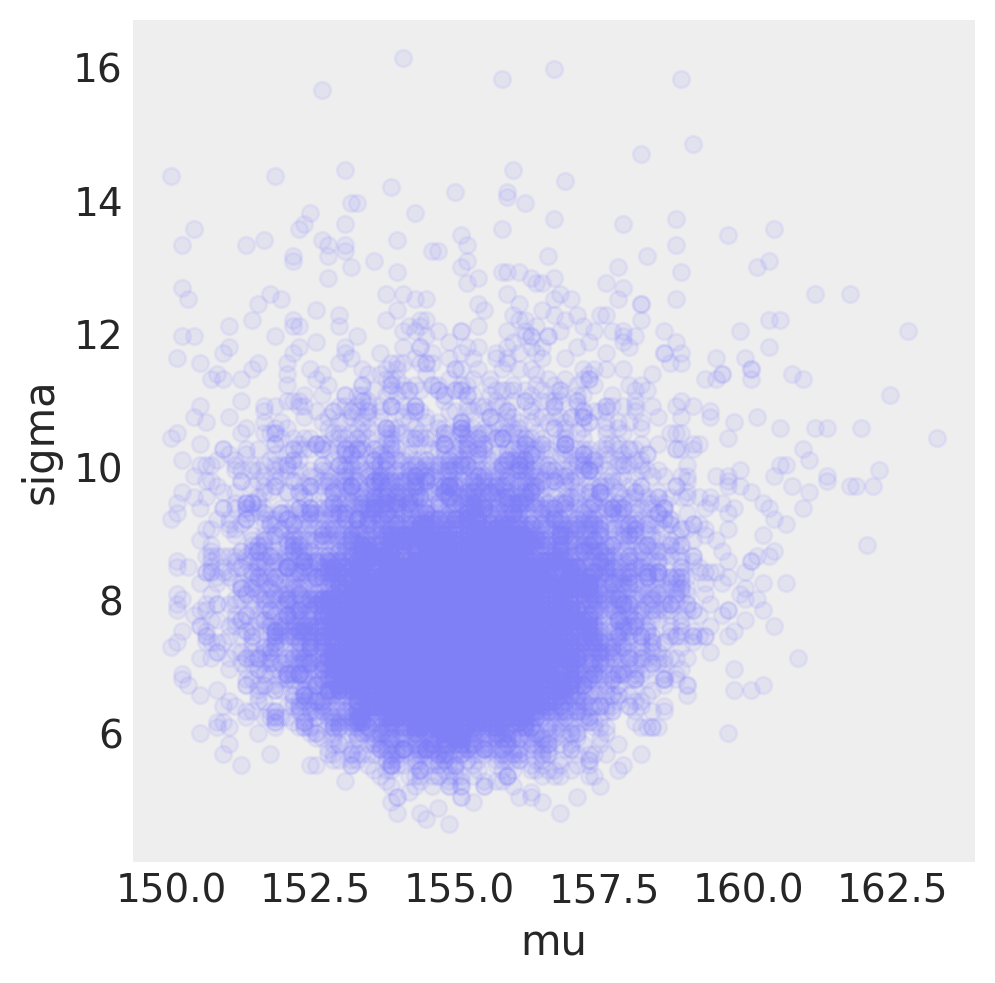

In [113]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.plot(sample2_mu, sample2_sigma, 'o', color="#8080FF", alpha=0.1)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.grid(False);Approximation

#### Code 4.25

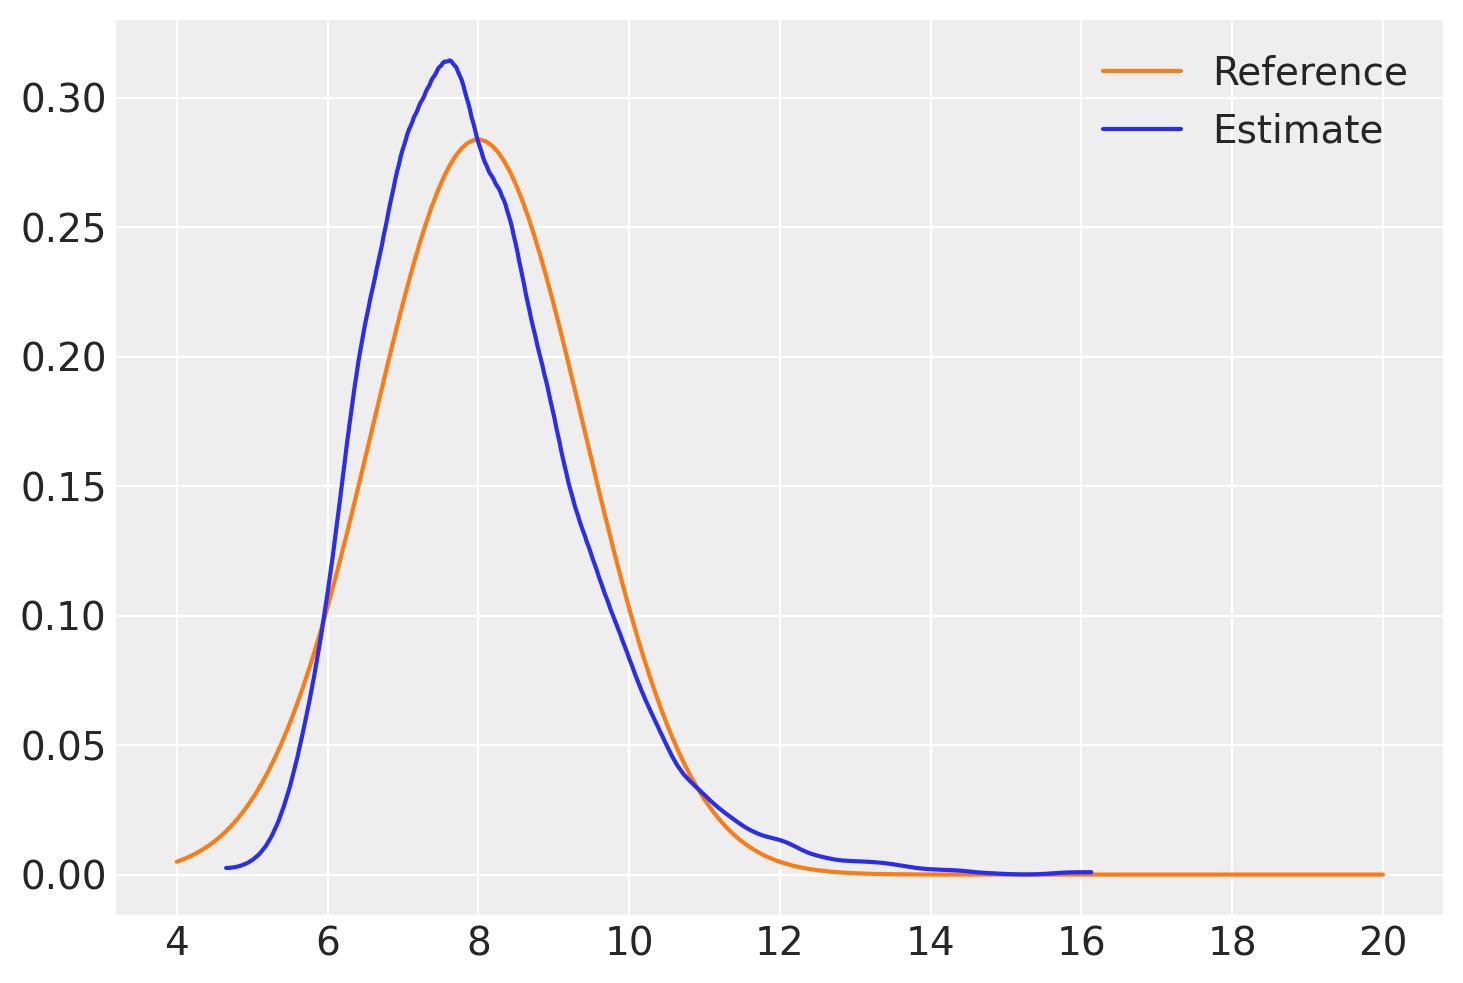

In [118]:
grid = np.linspace(4, 20, 200)
plt.plot(grid, stats.norm.pdf(grid, sample2_sigma.mean(), sample2_sigma.std()), color="C1", label="Reference")
az.plot_kde(sample2_sigma, bw="silverman", label="Estimate")
plt.legend(loc=0);

#### Code 4.26
We read the data again

In [120]:
d = pd.read_csv("data/Howell1.csv")
d2 = d[d.age >= 18]

#### Code 4.27 and 4.28

Note here we are using MCMC instead of quadratic approximation.

In [164]:
# Uniform prior for the intercept
priors = {
    'Intercept': bmb.Prior('Normal', mu=178, sd=20),
    'height_sigma': bmb.Prior('Uniform', lower=0, upper=50)
} 
model = bmb.Model('height ~ 1', d2, priors=priors)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Code 4.29

In [136]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,154.589,0.415,153.829,155.355,0.010,0.007,1756.0,1460.0,1.0
height_sigma,7.751,0.287,7.256,8.323,0.007,0.005,1768.0,1377.0,1.0


#### Code 4.30
Since priors don't change, we can reutilize the previous `model` object.

In [165]:
start = {
    "height": d2.height.mean(),
    "height_sigma": d2.height.std(),
}
results = model.fit(start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Code 4.31

In [166]:
priors = {
    'Intercept': bmb.Prior('Normal', mu=178, sd=0.1),
    'height_sigma': bmb.Prior('Uniform', lower=0, upper=50)
} 
model2 = bmb.Model('height ~ 1', d2, priors=priors)
results2 = model2.fit(start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [167]:
az.summary(results2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,177.861,0.102,177.672,178.046,0.002,0.002,1772.0,1431.0,1.0
height_sigma,24.460,0.916,22.668,26.202,0.023,0.016,1601.0,1230.0,1.0


#### Code 4.32
Note we are using the first model, not the last we fitted.

In [170]:
mu = results.posterior["Intercept"].values.ravel()
sigma = results.posterior["height_sigma"].values.ravel()
np.cov(mu, sigma)

array([[0.16874533, 0.00119348],
       [0.00119348, 0.07828437]])

#### Code 4.33

In [172]:
np.corrcoef(mu, sigma)

array([[1.        , 0.01038391],
       [0.01038391, 1.        ]])

#### Code 4.34

#### Code 4.35

#### Code 4.36

#### Code 4.37

#### Code 4.38

#### Code 4.39

#### Code 4.40

#### Code 4.41

#### Code 4.42

#### Code 4.43

#### Code 4.44

#### Code 4.45

#### Code 4.46